### Problem Formulation
At what AQI thresholds are there increases in short-term respiratory-related hospitalizations, and when might it be appropriate to issue public health advisories and make recommendations to public health agencies and officials?

### Data Acquisition

In [1]:
import _sqlite3
import pandas as pd
import numpy as np
import glob
from pathlib import Path

# The project paths
ROOT = Path("..") # This notebook is not in the root
RAW_DIR = ROOT / "data" / "raw"
PROCESSED_DIR = ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Paths to the raw data (CDC and AQI, respectively)
CDC_PATH = RAW_DIR / "CDC" / "cdc_raw.csv"
AQI_DIR = RAW_DIR / "AQI"

# Test that the paths are working expectedly
print("ROOT: ", ROOT.resolve())
print("CDC_PATH exists:", CDC_PATH.exists())
print("AQI_DIR exists:", AQI_DIR.exists())

ROOT:  /Users/kthomas/Desktop/CAP5771/CAP5771-Milestone-1
CDC_PATH exists: True
AQI_DIR exists: True


In [2]:
# Load and process the CDC data into "cdc_m1"
cdc_raw = pd.read_csv(CDC_PATH, low_memory=False)

# Create cdc_m1 table with only the CDC cols that we need
cdc_m1 = cdc_raw[[
    "weekendingdate",
    "jurisdiction",
    "totalconfc19hosppats",
    "totalconffluhosppats",
    "totalconfrsvhosppats"
]].copy()

# Rename the cols for consistency
cdc_m1 = cdc_m1.rename(columns={
    "weekendingdate": "week",
    "jurisdiction": "state",
    "totalconfc19hosppats": "covid_admissions",
    "totalconffluhosppats": "influenza_admissions",
    "totalconfrsvhosppats": "rsv_admissions"
})

# Make the week column dtype datetime and standardize the state column
cdc_m1["week"] = pd.to_datetime(cdc_m1["week"]).dt.normalize()
cdc_m1["state"] = cdc_m1["state"].astype(str).str.strip().str.upper()

# Make the admissions columns numeric
for c in ["covid_admissions", "influenza_admissions", "rsv_admissions"]:
    cdc_m1[c] = pd.to_numeric(cdc_m1[c], errors="coerce")

# Create a total_respiratory_admissions column by adding the three total admission columns together
cdc_m1["total_respiratory_admissions"] = (
    cdc_m1["covid_admissions"].fillna(0)
    + cdc_m1["influenza_admissions"].fillna(0)
    + cdc_m1["rsv_admissions"].fillna(0)
)

cdc_m1.head()

,week,state,covid_admissions,influenza_admissions,rsv_admissions,total_respiratory_admissions
0,2021-10-09,AL,1230.00,8.50,NaN,1238.50
1,2021-10-16,AL,962.57,4.00,NaN,966.57
2,2021-10-23,AL,707.91,8.00,NaN,715.91
3,2021-10-30,AL,554.86,8.86,NaN,563.72
4,2021-11-06,AL,451.71,10.14,NaN,461.85


In [3]:
# Load and process the AQI raw data

# Sort and gather the AQI files in the AQI directory
aqi_files = sorted(glob.glob(str(AQI_DIR / "*.csv")))
if not aqi_files:
    raise FileNotFoundError(f"No AQI data found in {AQI_DIR}")

# Concat the sorted AQI files
aqi_daily_raw = pd.concat((pd.read_csv(f) for f in aqi_files), ignore_index=True)

# Only gather the cols we need from the raw daily AQI data
aqi_daily = aqi_daily_raw[[
    "Date",
    "State Name",
    "AQI"
]].copy()

# Rename the columns for consistency
aqi_daily = aqi_daily.rename(columns={
    "Date": "date",
    "State Name": "state",
    "AQI": "aqi"
})

# Update the dtypes of date and aqi to datetime and numeric, respectively
aqi_daily["date"] = pd.to_datetime(aqi_daily["date"])
aqi_daily["aqi"] = pd.to_numeric(aqi_daily["aqi"], errors="coerce")

# Weekly ending Saturday, then normalize to date-only
aqi_daily["week"] = aqi_daily["date"].dt.to_period("W-SAT").apply(lambda r: r.end_time)
# Normalize the week times so they match the CDC weeks and can merge
aqi_daily["week"] = pd.to_datetime(aqi_daily["week"]).dt.normalize()

# Aggregate into weekly state-level AQI
aqi_m1 = (
    aqi_daily
    .groupby(["state", "week"], as_index=False)
    .agg(
        aqi_mean=("aqi", "mean"),
        aqi_p90=("aqi", lambda s: s.quantile(0.90)),
        aqi_max=("aqi", "max"),
        days_reported=("aqi", "count")
    )
)

# Examine the top five rows of aqi_m1
aqi_m1.head()

,state,week,aqi_mean,aqi_p90,aqi_max,days_reported
0,Alabama,2021-01-02,33.285714,53.0,55,21
1,Alabama,2021-01-09,42.246154,56.0,63,65
2,Alabama,2021-01-16,45.522388,61.0,72,67
3,Alabama,2021-01-23,39.500000,59.2,67,60
4,Alabama,2021-01-30,36.457627,56.6,67,59


In [4]:
# Robustly map the AQI state names to their abbreviations. This took a long time to debug and get done correctly.
US_STATE_ABBR = {
    "Alabama":"AL","Alaska":"AK","Arizona":"AZ","Arkansas":"AR","California":"CA","Colorado":"CO",
    "Connecticut":"CT","Delaware":"DE","District of Columbia":"DC","Florida":"FL","Georgia":"GA",
    "Hawaii":"HI","Idaho":"ID","Illinois":"IL","Indiana":"IN","Iowa":"IA","Kansas":"KS","Kentucky":"KY",
    "Louisiana":"LA","Maine":"ME","Maryland":"MD","Massachusetts":"MA","Michigan":"MI","Minnesota":"MN",
    "Mississippi":"MS","Missouri":"MO","Montana":"MT","Nebraska":"NE","Nevada":"NV","New Hampshire":"NH",
    "New Jersey":"NJ","New Mexico":"NM","New York":"NY","North Carolina":"NC","North Dakota":"ND","Ohio":"OH",
    "Oklahoma":"OK","Oregon":"OR","Pennsylvania":"PA","Rhode Island":"RI","South Carolina":"SC","South Dakota":"SD",
    "Tennessee":"TN","Texas":"TX","Utah":"UT","Vermont":"VT","Virginia":"VA","Washington":"WA",
    "West Virginia":"WV","Wisconsin":"WI","Wyoming":"WY",
    "Puerto Rico":"PR","Guam":"GU","Virgin Islands":"VI","American Samoa":"AS","Northern Mariana Islands":"MP"
}

def normalize_state_name(s: str) -> str:
    s = str(s).strip()
    # collapse multiple spaces
    s = " ".join(s.split())
    # common DC casing variants
    if s.lower() in {"district of columbia", "district of columbia ", "d.c.", "dc"}:
        return "District of Columbia"
    # title case for matching dict keys (handles 'new york' -> 'New York')
    return s.title()

# Normalize
aqi_m1["state_norm"] = aqi_m1["state"].apply(normalize_state_name)

# If already 2-letter abbreviations, keep them; else map full names
aqi_m1["state_abbr"] = np.where(
    aqi_m1["state_norm"].str.len() == 2,
    aqi_m1["state_norm"].str.upper(),
    aqi_m1["state_norm"].map(US_STATE_ABBR)
)

# Drop any rows of data outside the U.S.
aqi_m1 = aqi_m1[aqi_m1["state_abbr"].notna()].copy()

# Diagnostics
unmapped = aqi_m1.loc[aqi_m1["state_abbr"].isna(), "state"].dropna().unique()
print("Unmapped count:", len(unmapped))
print("First 20 unmapped examples:", unmapped[:20])
print("Example mapped:", aqi_m1["state_abbr"].dropna().unique()[:10])

# Update the aqi_m1 state column after the states have been properly mapped to their abbreviations
aqi_m1["state"] = aqi_m1["state_abbr"]

Unmapped count: 0
First 20 unmapped examples: []
Example mapped: ['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL']


In [5]:
# Compatibility checks before we merge the datasets
print("CDC weeks:", cdc_m1["week"].min(), "to", cdc_m1["week"].max())
print("AQI weeks:", aqi_m1["week"].min(), "to", aqi_m1["week"].max())

state_overlap = set(cdc_m1["state"]).intersection(set(aqi_m1["state"]))
week_overlap = set(cdc_m1["week"]).intersection(set(aqi_m1["week"]))
print("Overlapping states:", len(state_overlap))
print("Overlapping weeks:", len(week_overlap))

CDC weeks: 2020-08-08 00:00:00 to 2026-02-07 00:00:00
AQI weeks: 2021-01-02 00:00:00 to 2025-11-15 00:00:00
Overlapping states: 53
Overlapping weeks: 255


In [6]:
# Merge the datasets... finally
merged_m1 = pd.merge(
    cdc_m1,
    aqi_m1,
    on=["state", "week"],
    how="inner"
)

# Get rid of the helper columns
merged_m1 = merged_m1[[
    "state",
    "week",
    "covid_admissions",
    "influenza_admissions",
    "rsv_admissions",
    "total_respiratory_admissions",
    "aqi_mean",
    "aqi_p90",
    "aqi_max",
    "days_reported"
]].copy()

print(merged_m1.shape)
merged_m1.head()

(13080, 10)


,state,week,covid_admissions,influenza_admissions,rsv_admissions,total_respiratory_admissions,aqi_mean,aqi_p90,aqi_max,days_reported
0,AL,2021-10-09,1230.00,8.50,NaN,1238.50,34.580645,52.6,80,93
1,AL,2021-10-16,962.57,4.00,NaN,966.57,40.752577,57.0,67,97
2,AL,2021-10-23,707.91,8.00,NaN,715.91,40.423913,55.0,65,92
3,AL,2021-10-30,554.86,8.86,NaN,563.72,30.712766,44.4,70,94
4,AL,2021-11-06,451.71,10.14,NaN,461.85,38.166667,52.0,57,66


In [7]:
# Save all three of the processed files to the processed data folder

cdc_m1.to_csv(PROCESSED_DIR / "cdc_m1.csv", index=False)
aqi_m1.to_csv(PROCESSED_DIR / "aqi_m1.csv", index=False)
merged_m1.to_csv(PROCESSED_DIR / "merged_m1.csv", index=False)

### Data Acquistion II (Database)

In [8]:
# Create the DB file!!!
db_path = PROCESSED_DIR / "milestone1.db"
conn = _sqlite3.connect(db_path)

cdc_m1.to_sql("cdc_m1", conn, index=False, if_exists="replace")
aqi_m1.to_sql("aqi_m1", conn, index=False, if_exists="replace")
merged_m1.to_sql("merged_m1", conn, index=False, if_exists="replace")

conn.close()

### Data Exploration

In [9]:
import matplotlib.pyplot as plt

db_path = PROCESSED_DIR / "milestone1.db"
conn = _sqlite3.connect(db_path)

df = pd.read_sql_query("SELECT * FROM merged_m1", conn)

# Sanity check for duplicated rows
print("Number of duplicates:", df.duplicated().sum())

Number of duplicates: 0


In [10]:
# Calculation of value missing rates (null values) for applicable variables
missing_rates = df.isnull().mean() * 100

applicable_variables = [
    'covid_admissions', 
    'influenza_admissions', 
    'rsv_admissions', 
    'days_reported'
]

print("Missingness Rates (Percentage):")
print(missing_rates[applicable_variables])

Missingness Rates (Percentage):
covid_admissions         0.420489
influenza_admissions     0.420489
rsv_admissions          66.559633
days_reported            0.000000
dtype: float64


A significant portion of RSV admissions are missing (66.55%!!)

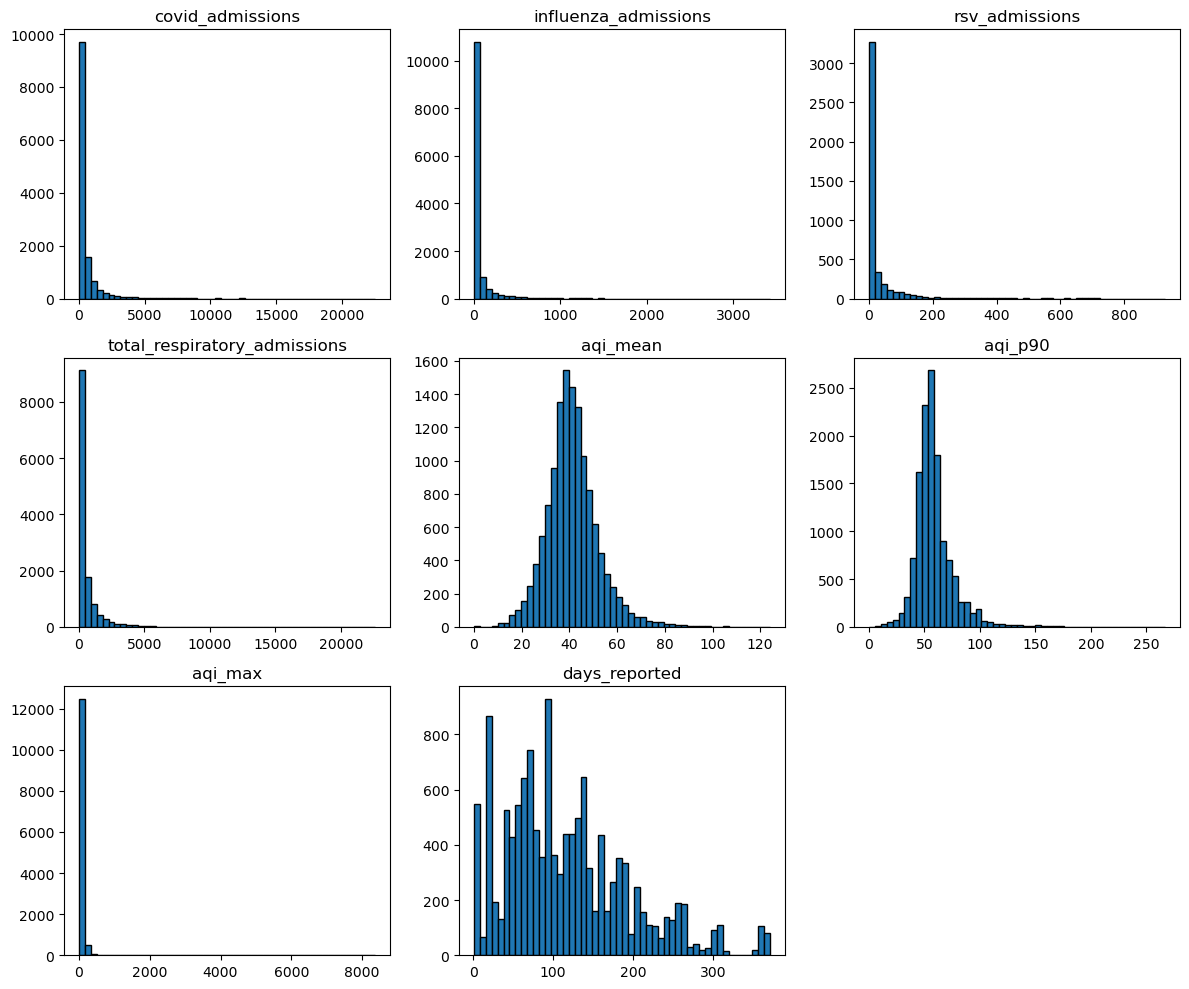

In [11]:
# Histograms displaying summary statistics about every variable
df.hist(
    figsize=(12, 10),
    bins=50,
    grid=False,
    edgecolor="black"
)

plt.tight_layout()
plt.show()

In [12]:
# Skew Statistics (Measures asymmetry of distribution)
df.skew(numeric_only=True)

covid_admissions                 7.550033
influenza_admissions             7.769326
rsv_admissions                   5.226334
total_respiratory_admissions     7.043028
aqi_mean                         0.842691
aqi_p90                          2.226002
aqi_max                         38.955189
days_reported                    0.889415
dtype: float64

In [13]:
# Kurt Statistics (Measures heaviness of tails relative to normal distribution)
df.kurt(numeric_only=True)

covid_admissions                  83.707630
influenza_admissions              86.407713
rsv_admissions                    35.799407
total_respiratory_admissions      75.435163
aqi_mean                           2.979186
aqi_p90                           11.013621
aqi_max                         2175.897629
days_reported                      0.543498
dtype: float64

As highlighted by the histogram plots, skew statistics and kurt statistics, several variables are significantly positively skewed and feature extremely long tails. This is likely due to the prescence of extreme outliers that are significantly affecting specific variables overall distribution.

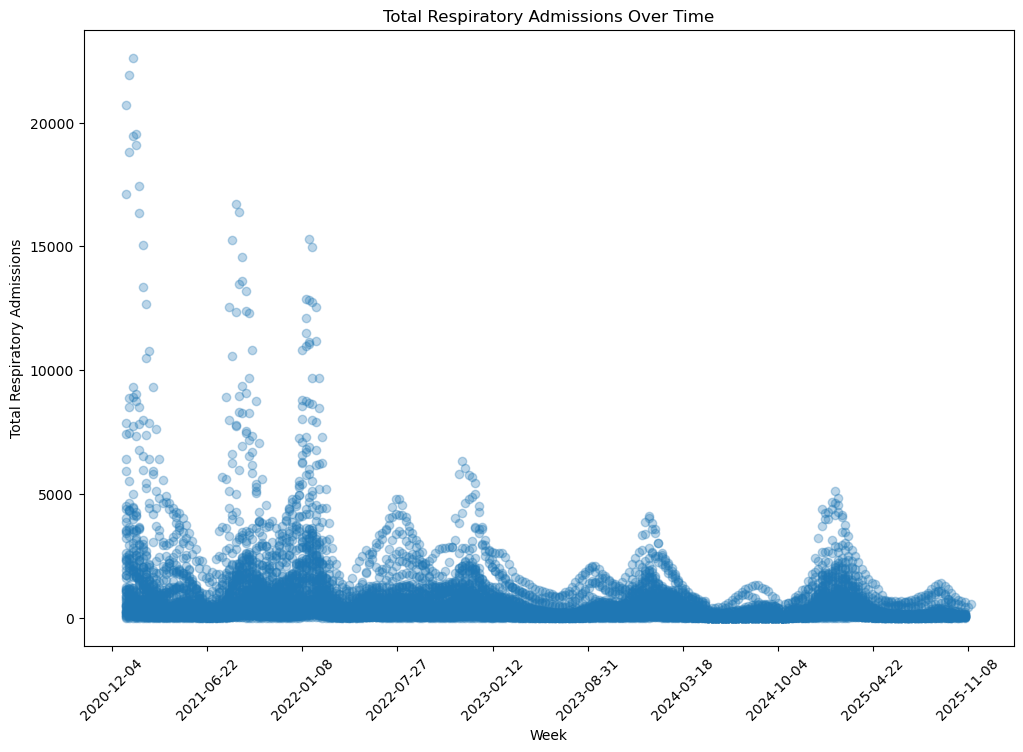

In [14]:
# Plot of Total Respiratory Admissions over time
import matplotlib.ticker as ticker

df["week"] = pd.to_datetime(df["week"])
df_time_sorted = df.sort_values(by="week", ascending=True)

plt.figure(figsize=(12, 8))
plt.scatter(df_time_sorted["week"], df_time_sorted["total_respiratory_admissions"], alpha=0.3)
plt.xlabel("Week")
plt.ylabel("Total Respiratory Admissions")
plt.title("Total Respiratory Admissions Over Time")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)
plt.show()

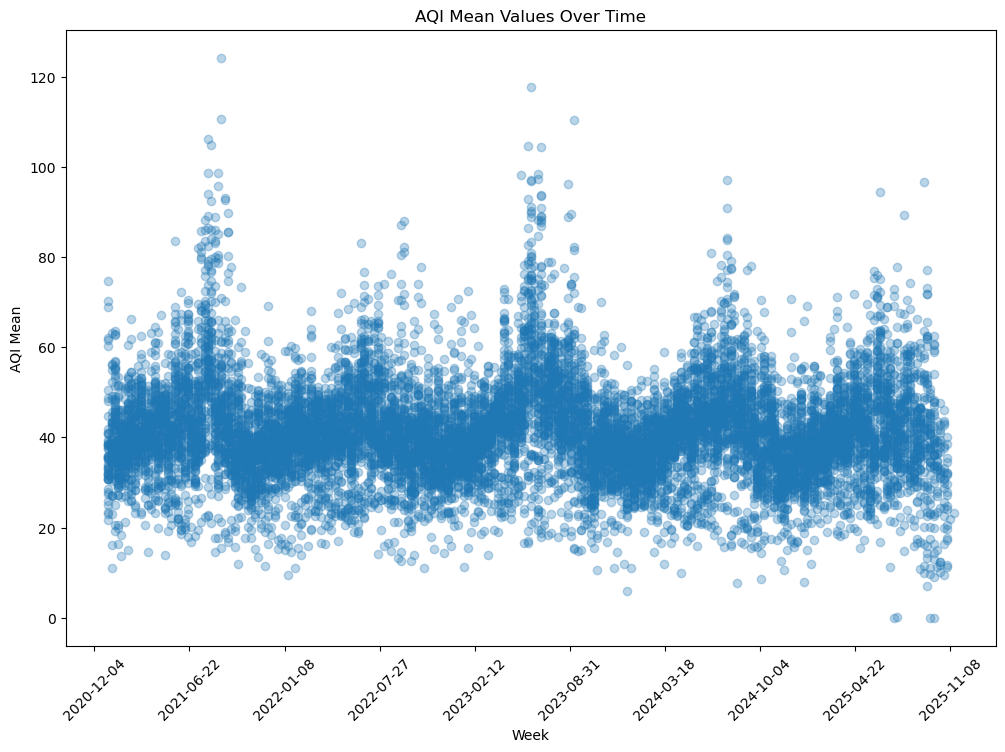

In [15]:
# Plot of AQI Mean Values over time
plt.figure(figsize=(12, 8))
plt.scatter(df_time_sorted["week"], df_time_sorted["aqi_mean"], alpha=0.3)
plt.xlabel("Week")
plt.ylabel("AQI Mean")
plt.title("AQI Mean Values Over Time")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
plt.xticks(rotation=45)
plt.show()

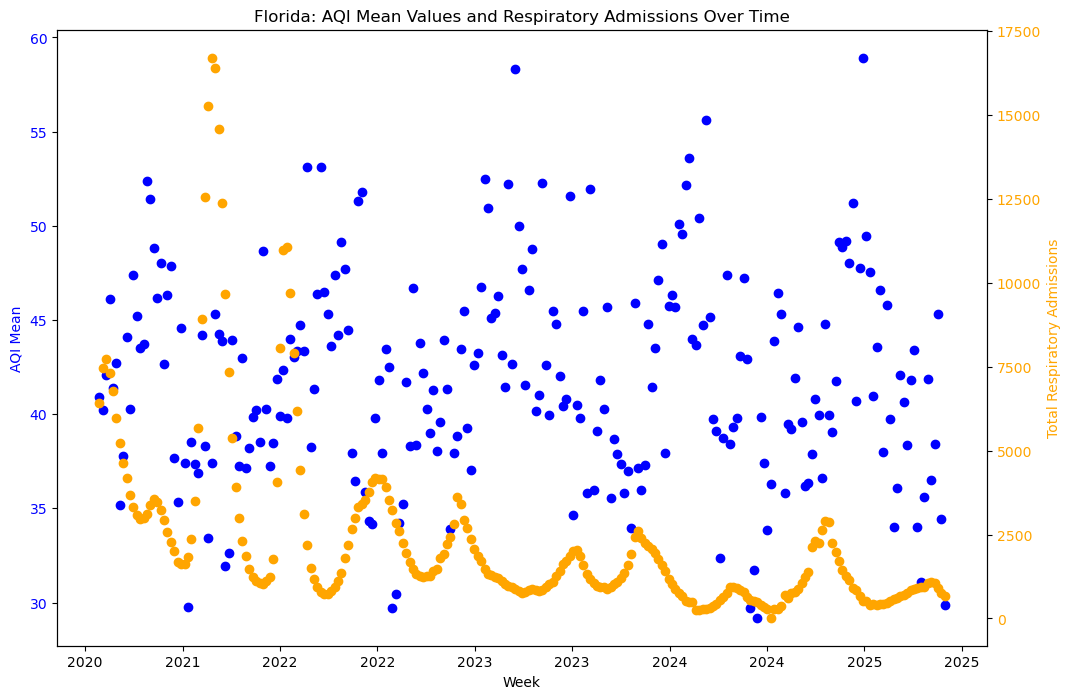

In [18]:
# Plot of AQI Mean Values and Respiratory Admissions over time for the state of Florida
df_fl = df[df["state"] == "FL"]
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.set_xlabel('Week')
ax1.set_ylabel('AQI Mean', color="blue")
ax1.scatter(df_fl["week"], df_fl["aqi_mean"], color="blue", label="AQI")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

ax2 = ax1.twinx()
ax2.set_ylabel('Total Respiratory Admissions', color="orange")
ax2.scatter(df_fl["week"], df_fl["total_respiratory_admissions"], color="orange", label="Admissions")
ax2.tick_params(axis='y', labelcolor="orange")

plt.title("Florida: AQI Mean Values and Respiratory Admissions Over Time")
plt.show()